In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.nn import functional as f
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np
import collections
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from moco_model import MoCo
import time
import itertools
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"


In [2]:
def split_train_validation_randomly(original_path, target_path):
    original_images = list(sorted(list(map(str, list(Path(original_path).glob('*.jpg'))))))
    target_images = list(sorted(list(map(str, list(Path(target_path).glob('*.jpg'))))))
    images = list(zip(original_images, target_images))
    train_images, val_images = torch.utils.data.random_split(images, [160, 24])
    return train_images, val_images

class ThreeChannelNDIDatasetContrastiveLearningWithAug(Dataset):
    def __init__(self, images, evaluate=False):
        super(ThreeChannelNDIDatasetContrastiveLearningWithAug, self).__init__()
        if not evaluate:
            self.images = images[0]
        else:
            self.images = images[1]
        # 水平翻转 + 随机旋转 训练慢（100）但是效果好
        self.transforms = transforms.Compose([
            # transforms.GaussianBlur(kernel_size=3, sigma=0.7),
            # transforms.CenterCrop(150),
            # transforms.Resize(200),
            # transforms.RandomHorizontalFlip(0.5),
            # transforms.RandomRotation(30)
            ])
        self.evaluate = evaluate

    def __getitem__(self, idx):
        origin_path, target_path = self.images[idx]
        origin = Image.open(origin_path).convert('RGB')
        target = Image.open(target_path)
        if not self.evaluate:
            origin, target = self.transforms(torch.cat((transforms.ToTensor()(origin).unsqueeze(0), transforms.ToTensor()(target).unsqueeze(0)), dim=0))
        else:
            origin, target = transforms.ToTensor()(origin), transforms.ToTensor()(target)
        label = int(origin_path.split('/')[-1].split('.')[0]) - 1
        return origin, target, label

    def __len__(self):
        return len(self.images)

In [19]:
ORIGINAL_IMAGE = 'E:/datasets/NDI_images/Integreted/Observed/circle_binaryzation_pics'
TARGET_IMAGE = 'E:/datasets/NDI_images/Integreted/Calculated/'
k_values = [48]
top_k_candidates = (10, 20, 30)
images = split_train_validation_randomly(ORIGINAL_IMAGE, TARGET_IMAGE)
train_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, False)
val_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, True)
train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))
metrics = {}
for k in k_values:
    model = MoCo(torchvision.models.resnet18, dim=512, K=k, model_type='resnet', pretrained=True, three_channel=True)
    device = torch.device('cuda:0')
    criterion = nn.CrossEntropyLoss().cuda(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
    start_time = time.time()
    sub_metrics = train_moco_return_metrics_top_k(model, criterion, optimizer, 50, device, top_k_candidates)
    end_time = time.time()
    metrics[k] = sub_metrics.data
    metrics[k]['Training time'] = round(end_time - start_time, 2)

Epoch 1, Train_Loss 3.4319420077605174, Val_loss 4.370969295501709
Train_acc_top_10 0.04	Train_acc_top_20 0.12	Train_acc_top_30 0.2	
Val_acc_top_10 0.12	Val_acc_top_20 0.17	Val_acc_top_30 0.17	
Epoch 2, Train_Loss 3.8713782787323, Val_loss 4.388139724731445
Train_acc_top_10 0.04	Train_acc_top_20 0.11	Train_acc_top_30 0.2	
Val_acc_top_10 0.04	Val_acc_top_20 0.08	Val_acc_top_30 0.17	
Epoch 3, Train_Loss 3.6899520635604857, Val_loss 3.495112657546997
Train_acc_top_10 0.04	Train_acc_top_20 0.08	Train_acc_top_30 0.12	
Val_acc_top_10 0.04	Val_acc_top_20 0.21	Val_acc_top_30 0.21	
Epoch 4, Train_Loss 3.4893131971359255, Val_loss 3.587373733520508
Train_acc_top_10 0.06	Train_acc_top_20 0.11	Train_acc_top_30 0.17	
Val_acc_top_10 0.12	Val_acc_top_20 0.25	Val_acc_top_30 0.29	
Epoch 5, Train_Loss 3.3785370588302612, Val_loss 3.75921368598938
Train_acc_top_10 0.09	Train_acc_top_20 0.18	Train_acc_top_30 0.22	
Val_acc_top_10 0.08	Val_acc_top_20 0.21	Val_acc_top_30 0.29	
Epoch 6, Train_Loss 3.028026604

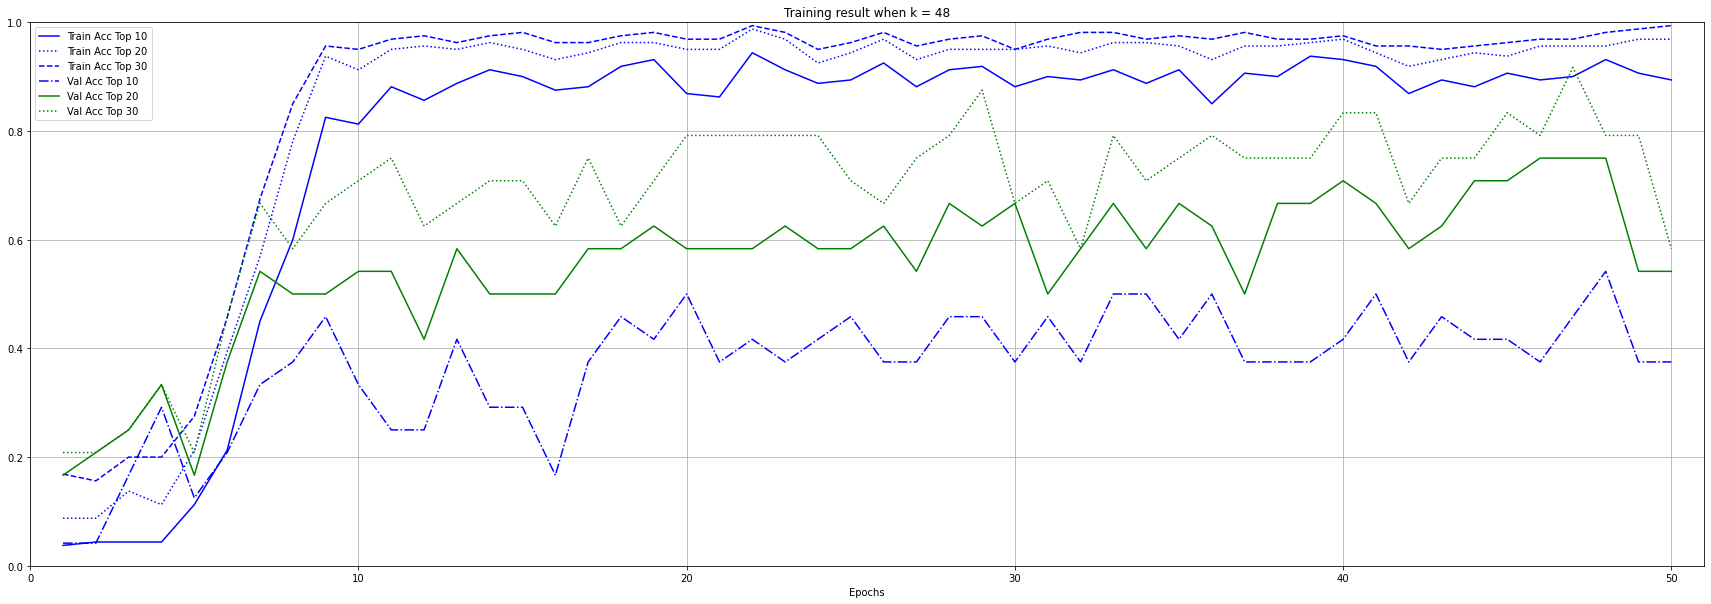

In [15]:
draw_graph(metrics, 50, top_k_candidates)

In [3]:
class HistoryRecorder:
    def __init__(self, metrics_names: (list, tuple), parameter_names: (list, tuple)):
        self.data = {}
        self.metrics_names = metrics_names
        self.parameter_names = parameter_names

    def add(self, data: dict):
        # if len(self.names) < len(args):
        #     raise IndexError('Too much values to record')
        # else:
        #     for i in range(min(len(self.names), len(args))):
        #         if isinstance(self.data[self.names[i]], list):
        #             self.data[self.names[i]].append(args[i])
        #         elif isinstance(self.data[self.names[i]], dict):
        #             for k, v in args[i].items():
        #                 if k not in self.data[self.names[i]]:
        #                     self.data[self.names[i]][k] = [v]
        #                 else:
        #                     self.data[self.names[i]][k].append(v)
        self.data.update(data)

    def reset(self):
        self.data = {}

    def __getitem__(self, name):
        return self.data[name]

def cal_accuracy_top_k(preds, label, top_k=(1, )):
    result = []
    max_k = max(top_k)
    sample_num = preds.shape[0]
    pred_scores, pred_labels = preds.topk(max_k, dim=1)
    pred_labels = pred_labels.t()
    correct = pred_labels.eq(label.view(1, -1).expand_as(pred_labels))
    for k in top_k:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        result.append(correct_k.item())
    return result

def image_pair_matching(net, original_image, matching_image):
    net.eval()
    q = net.encoder_q(original_image)
    q = f.normalize(q, dim=1)
    k = net.encoder_k(matching_image)
    k = f.normalize(k, dim=1)
    logits = torch.einsum('nc,ck->nk', [q, k.T])
    return logits

def train_moco_return_metrics_top_k(net, criterion, optimizer, epochs, device, tested_parameter, k_candidates=(10, )):
    # train_metrics = HistoryRecorder(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'], [list, dict, list, dict])

    to_tensor_func = torchvision.transforms.ToTensor()
    target_tensor = []
    for i in range(1, 185):
        target_tensor.append(to_tensor_func(Image.open(str(Path.joinpath(Path(TARGET_IMAGE), f'{i}.jpg')))).unsqueeze(0))
    target_tensor = torch.cat(target_tensor, dim=0)
    target_tensor = target_tensor.cuda(device)
    train_loss_record = []
    train_acc_record = {k: [] for k in k_candidates}
    val_loss_record = []
    val_acc_record = {k: [] for k in k_candidates}
    for epoch in range(epochs):
        net.cuda(device)
        total_loss = 0
        training_correct = collections.defaultdict(int)
        training_size = 0
        for origin, target, label in train_iter:
            net.train()
            origin, target, label = origin.cuda(device), target.cuda(device), label.cuda(device)
            output, labels = net(origin, target)
            loss = criterion(output, labels)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            net.eval()
            with torch.no_grad():
                for k, correct in zip(k_candidates, cal_accuracy_top_k(image_pair_matching(net, origin, target_tensor), label, top_k=k_candidates)):
                    training_correct[k] += correct
                training_size += origin.shape[0]
        net.eval()
        with torch.no_grad():
            val_loss = 0
            val_correct = collections.defaultdict(int)
            for origin, target, label in val_iter:
                origin, target, label = origin.cuda(device), target.cuda(device), label.cuda(device)
                output, labels = net(origin, target, evaluate=True)
                val_loss += f.cross_entropy(output, labels).item()
                for k, correct in zip(k_candidates, cal_accuracy_top_k(image_pair_matching(net, origin, target_tensor), label, top_k=k_candidates)):
                    val_correct[k] += correct
        val_acc = {k: correct / origin.shape[0] for k, correct in val_correct.items()}
        train_acc = {k: correct / training_size for k, correct in training_correct.items()}
        train_loss_record.append(total_loss / len(train_iter))
        for k, v in train_acc.items():
            train_acc_record[k].append(v)
        val_loss_record.append(val_loss / len(val_iter))
        for k, v in val_acc.items():
            val_acc_record[k].append(v)
        print(f'Epoch {epoch + 1}, Train_Loss {total_loss / len(train_iter)}, Val_loss {val_loss / len(val_iter)}')
        for k, acc in train_acc.items():
            print(f'Train_acc_top_{k} {round(acc, 4)}', end='\t')
        print()
        for k, acc in val_acc.items():
            print(f'Val_acc_top_{k} {round(acc, 2)}', end='\t')
        print()
    return {tuple(tested_parameter): (train_loss_record, train_acc_record, val_loss_record, val_acc_record)}

def fmts_gen():
        line_styles = ['-', ':', '--', '-.']
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'w']
        for color in colors:
            for line_style in line_styles:
                yield color + line_style

def draw_graph(metrics, num_epochs: int, metrics_name: (list, tuple)):
    X = np.arange(1, num_epochs + 1, 1)
    fig, axes = plt.subplots((len(metrics) + 1) // 2, 2, figsize=(15, 20))
    if hasattr(axes, 'flatten'):
        axes = axes.flatten()
    else:
        axes = [axes]
    for i, (k, v) in enumerate(metrics.items()):
        fmts = fmts_gen()
        plot_data = [v[0]]
        plot_data.extend(v[1].values())
        plot_data.append(v[2])
        plot_data.extend(v[3].values())
        for y, fmt in zip(plot_data, fmts):
            axes[i].plot(X, y, fmt)
        axes[i].set_xlabel('Epochs')
        axes[i].set_xlim([0, num_epochs + 1])
        axes[i].set_ylim([0, 4])
        axes[i].legend(['Train Loss'] + [f'Train Acc Top {k}' for k in v[1].keys()] + ['Val Loss'] + [f'Val Acc Top {k}' for k in v[3].keys()])
        axes[i].grid()
        axes[i].set_title(f'Training result when ' + ', '.join([f'{name} = {value}' for name, value in zip(metrics_name, k)]))
    plt.show()

## Search parameters of temperature and momentum

In [7]:
ORIGINAL_IMAGE = '../datasets/NDI_images/Integreted/Observed/circle_binaryzation_pics'
TARGET_IMAGE = '../datasets/NDI_images/Integreted/Calculated/'
top_k_candidates = (10, 20, 30)
images = split_train_validation_randomly(ORIGINAL_IMAGE, TARGET_IMAGE)
train_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, False)
val_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, True)
train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))
temps = [0.7]
momentums = [0.999, 0.99, 0.9]
# momentums = [0.99]
k_value = 48
parameters = {'temp': temps, 'momentum': momentums}
train_metrics = HistoryRecorder(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'], list(parameters.keys()))
for parameter in itertools.product(*parameters.values()):

    ### custom part to get parameters
    temperature = parameter[0]
    momentum = parameter[1]
    ### END
    model = torchvision.models.vgg19_bn(weights='VGG19_BN_Weights.IMAGENET1K_V1')
    model.classifier[6] = nn.Linear(in_features=model.classifier[6].in_features, out_features=512)
    model = MoCo(model, dim=512, K=k_value, T=temperature, m=momentum, model_type='resnet', pretrained=True, three_channel=True, custom_model=True)
    device = torch.device('cuda:0')
    criterion = nn.CrossEntropyLoss().cuda(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    start_time = time.time()
    metrics = train_moco_return_metrics_top_k(model, criterion, optimizer, 50, device, tested_parameter=parameter, k_candidates=top_k_candidates)
    end_time = time.time()
    train_metrics.add(metrics)

Epoch 1, Train_Loss 3.847867012023926, Val_loss 3.5825588703155518
Train_acc_top_10 0.075	Train_acc_top_20 0.1437	Train_acc_top_30 0.1812	
Val_acc_top_10 0.04	Val_acc_top_20 0.12	Val_acc_top_30 0.17	
Epoch 2, Train_Loss 3.8776777267456053, Val_loss 3.595458745956421
Train_acc_top_10 0.0563	Train_acc_top_20 0.1187	Train_acc_top_30 0.1812	
Val_acc_top_10 0.04	Val_acc_top_20 0.21	Val_acc_top_30 0.25	
Epoch 3, Train_Loss 3.856772232055664, Val_loss 3.715609550476074
Train_acc_top_10 0.05	Train_acc_top_20 0.1187	Train_acc_top_30 0.1625	
Val_acc_top_10 0.0	Val_acc_top_20 0.08	Val_acc_top_30 0.25	
Epoch 4, Train_Loss 3.8178278684616087, Val_loss 3.7039897441864014
Train_acc_top_10 0.0563	Train_acc_top_20 0.125	Train_acc_top_30 0.175	
Val_acc_top_10 0.08	Val_acc_top_20 0.12	Val_acc_top_30 0.12	
Epoch 5, Train_Loss 3.7781428575515745, Val_loss 3.6867635250091553
Train_acc_top_10 0.0875	Train_acc_top_20 0.1562	Train_acc_top_30 0.2313	
Val_acc_top_10 0.04	Val_acc_top_20 0.08	Val_acc_top_30 0.17	


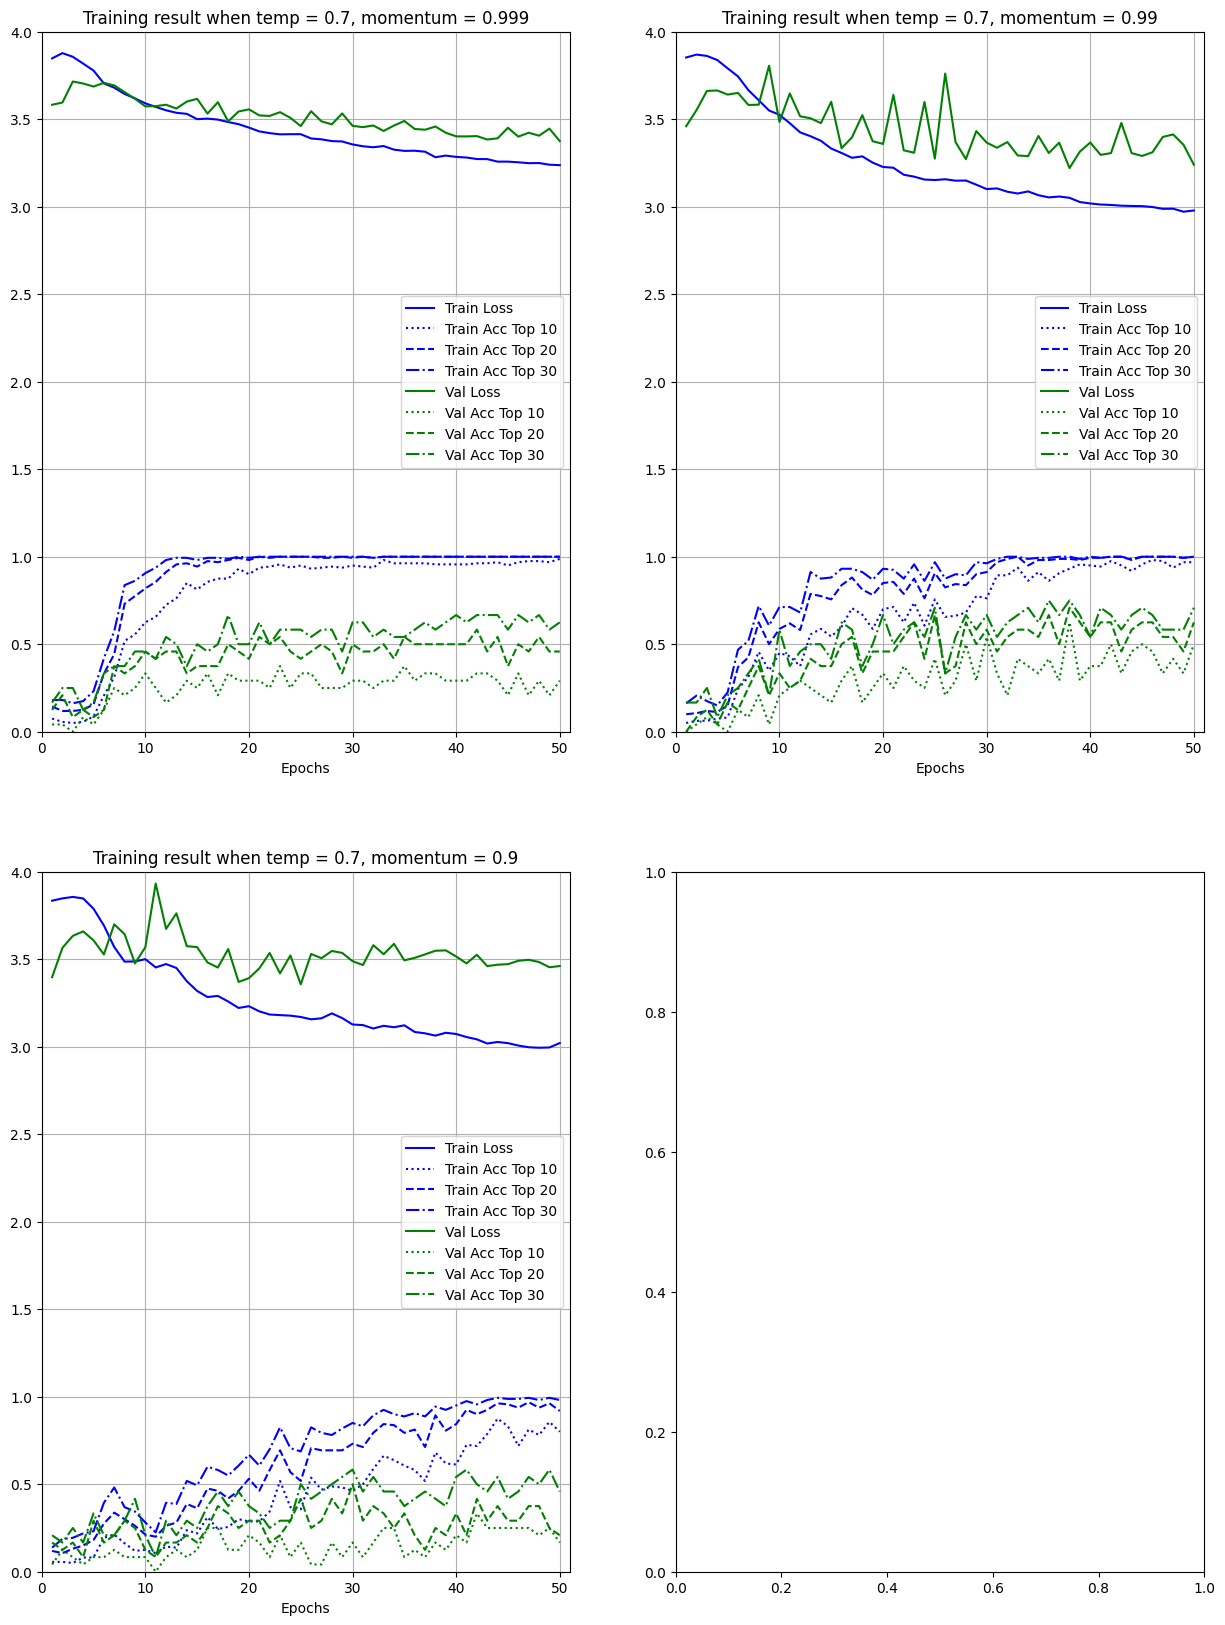

In [8]:
# Try on VGG

draw_graph(train_metrics.data, 50, ('temp', 'momentum'))

In [ ]:
# Find the optimal parameter of t=0.7, momentum=0.99 when there is no data augmentation using ResNet18

draw_graph(train_metrics.data, 50, ('temp', 'momentum'))

In [ ]:
# Follow above extend to 100 epochs
# No help

draw_graph(train_metrics.data, 100, ('temp', 'momentum'))

In [ ]:
# Search of k_values when t=0.7, momentum=[0.999, 0.99, 0.9] with no augmentation using ResNet18
# k_value=48 still the best
draw_graph(train_metrics.data, 50, ('temp', 'momentum', 'k_value'))

In [ ]:
# How about ResNet34?
# Similar to ResNet18

draw_graph(train_metrics.data, 50, ('temp', 'momentum'))

In [ ]:
# Find the optimal parameter of t=0.7, momentum=0.99 when there is no data augmentation using ResNet50
# Worse than ResNet18 maybe too powerful?
# LR=0.005
# ResNet50 too bad

draw_graph(train_metrics.data, 50, ('temp', 'momentum'))

In [ ]:
# Find the optimal parameter of t=0.7, momentum=0.99 when there is only up to 30 degrees random rotation using ResNet18
# But waves heavily than no data augmentation

draw_graph(train_metrics.data, 50, ('temp', 'momentum'))